# 线性可分支持向量机学习算法-最大间隔法

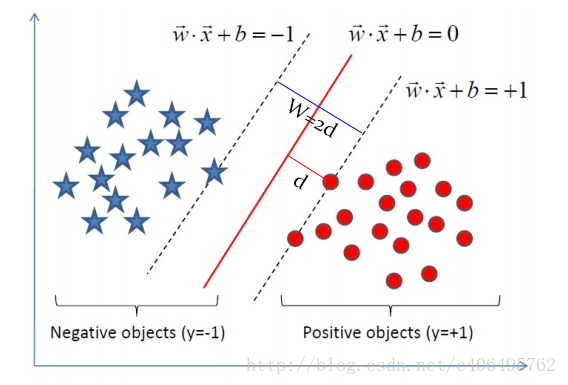

在样本空间中，划分超平面可通过如下线性方程来描述：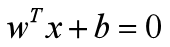
            
其中w=(w1;w2;...;wd)为法向量，决定了超平面的方向；b为位移项，决定了超平面与原点之间的距离。

样本空间中任意点x到超平面(w,b)的距离可写为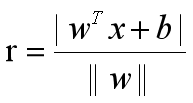
                     
            

假设超平面(w,b)能将训练样本正确分类，即对于(xi,yi)

若yi=+1,则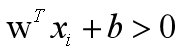

若yi=-1，则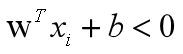即存在一个数d，满足        

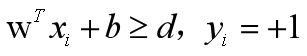  

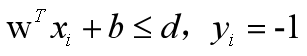

等式两边做缩放变换，同除以d，得到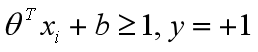
                   

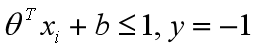

其中θ=w/d，因为θ就是符号代号，将它重新写为w。

距离超平面最近的这几个训练样本使上式等号成立，它们被称为“支持向量”，两个异类支持向量到超平面的距离之和为
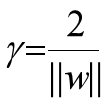
                    
它们被称为“间隔”                

欲找到具有“最大间隔”的划分超平面，也就是要找到满足上式的w和b，使得r最大。
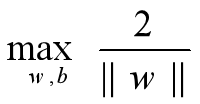

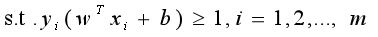

等价于
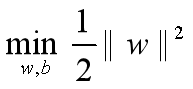               

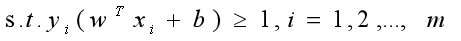这就是支持向量机的基本型。间隔貌似仅与w有关，但事实上b通过约束隐式地影响着w的取值，进而对间隔产生影响。

# 学习的对偶算法

首先构建拉格朗日函数，对每一个不等式约束引进拉格朗日乘子αi>=0,i=1,2,...,m,定义拉格朗日函数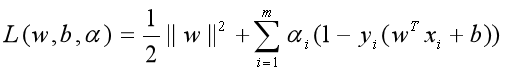根据拉格朗日对偶性，原始问题的对偶问题是极大极小的问题，即

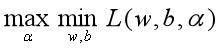(1)求min

将拉格朗日函数L(w,b,α)分别对w,b求偏导数并令其等于0，得

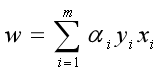

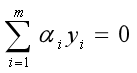将上式带入拉格朗日函数可得

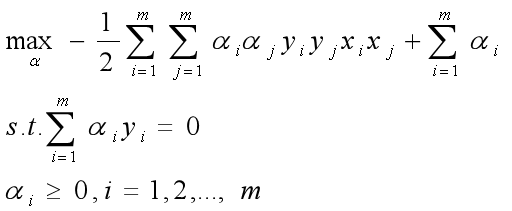解出α后，求出w与b即可得到模型

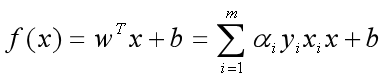

上述过程需满足KKT条件，即要求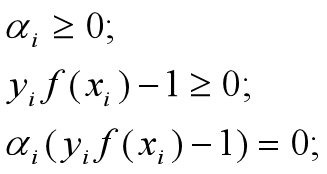于是，对任意训练样本(xi,yi)，总有αi=0或yif(xi)=1.若αi=0,则该样本将不会在上述求和中出现，也就不会对f(x)有任何影响;若αi>0,则必有yif(xi)=1，所对应的样本点位于最大间隔边界上，是一个支持向量。

# 线性支持向量机与软间隔最大化

线性不可分意味着某些样本点(xi,yi)不能满足函数间隔大于等于1的约束条件。为了解决这个问题，可以对每个样本点(xi,yi)引进一个松弛变量ξi>=0，使函数间隔加上松弛变量大于等于1，这样，约束条件变为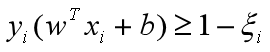同时，对每个松弛变量ξi支付一个代价ξi，目标函数由原来的1/2||w||^2变成

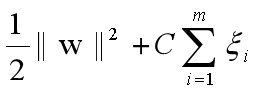这里，C>0称为惩罚参数。

线性不可分的线性支持向量机的学习问题变成如下凸二次规划问题(原始问题)：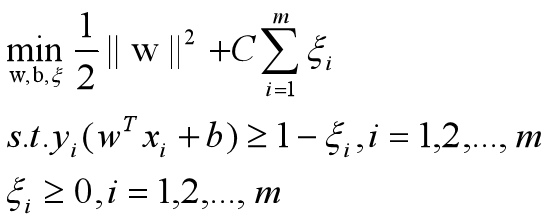

# 学习的对偶算法

参照线性可分支持向量机，可以得到拉格朗日函数：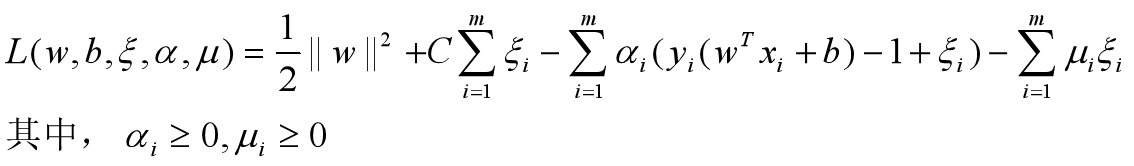对偶问题是拉格朗日函数的极大极小问题。

首先求L(w,b,ξ,α,μ)对w,b,ξ的偏导数并令其等于0，得

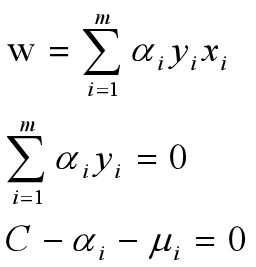将上式代入拉格朗日函数可得

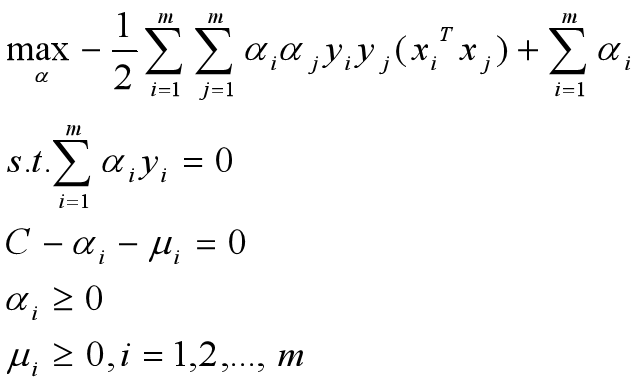将上式进行变换：利用等式约束消去μ，从而只留下α，从而得到对偶问题：

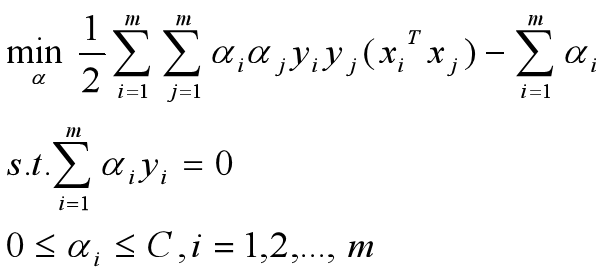

对软间隔支持向量机，KKT条件要求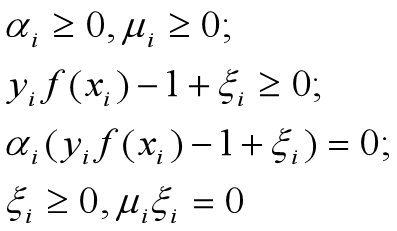于是，对任意训练样本(xi,yi)，总有αi=0,或yif(xi)=1-ξ.若αi=0,则样本不会对f(x)有任何影响；若αi>0,则必有yif(xi)=1-ξ，即该样本是支持向量。由C=αi+μi可知，若αi<C,则μi>0，进而有ξi=0，即该样本恰在最大间隔边界上；若αi=C,则有μi=0,此时若ξi<=1,则该样本落在最大间隔内部，若ξi>1,则该样本被错误分类。

对于SMO的介绍略，详见https://blog.csdn.net/c406495762/article/details/78072313

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [22]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

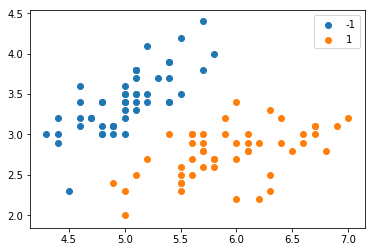

In [23]:
plt.scatter(X[:50,0],X[:50,1], label='-1')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [40]:
class SMO():
    def __init__(self):
        self.alphas=None
        self.m=None   #训练样本数
        self.g=None   #保存所有的g(x_i)
        self.E=None   #保存所有的E_i
        self.C=None   #软间隔
        self.b=None
        self.Xtrain=None
        self.ytrain=None



    def init_params(self,Xtrain,ytrain,C,b):
        m, n = Xtrain.shape
        ytrain = np.mat(ytrain).T  # shape(m,1)
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.alphas = np.zeros((m, 1))
        self.m = m
        self.C = C
        self.b = b
        self.calcg(Xtrain, ytrain)
        self.calcE(Xtrain, ytrain)
        print("init params done!")


    def calcE(self,Xtrain,ytrain):  #计算误差0

        E=self.g-ytrain
        self.E=E


    def calcg(self,Xtrain,ytrain):
        g=np.zeros((self.m,1))
        alpha_times_y=np.multiply(self.alphas,ytrain)  #shape:(m,1)
        for i in range(self.m):
            g[i]=alpha_times_y.T.dot(Xtrain.dot(Xtrain[i].T))+self.b
        self.g=g


    def updategi_Ei(self,index,Xtrain,ytrain):
        alpha_times_y = np.multiply(self.alphas, ytrain)  # shape:(m,1)
        for i in index:
            self.g[i] = alpha_times_y.T.dot(Xtrain.dot(Xtrain[i].T))+self.b
            self.E[i] = self.g[i] - ytrain[i]


    def selectI(self,i,ytrain):
        if ytrain[i]*self.g[i]==1 and 0<self.alphas[i]<self.C:
            return False
        elif ytrain[i]*self.g[i]>=1 and self.alphas[i]==0:
            return False
        elif ytrain[i]*self.g[i]<=1 and self.alphas[i]==self.C:
            return False
        return True



    def selectJ(self,i):
        E1=self.E[i]
        j = np.argmax(self.E)
        if E1>=0:
            j=np.argmin(self.E)
        return j


    def reSelectJ(self,i,index_list):
        flag=False
        jIndex=-1
        alpha2=0
        for j in index_list:
            if j!=i:
                if self.ytrain[i]==self.ytrain[j]:
                    L=max(0,self.alphas[j]+self.alphas[i]-self.C)
                    H=min(self.C,self.alphas[j]+self.alphas[i])
                else:
                    L=max(0,self.alphas[j]-self.alphas[i])
                    H=min(self.C,self.C+self.alphas[j]-self.alphas[i])
                eta=self.Xtrain[i].dot(self.Xtrain[i].T)+self.Xtrain[j].dot(self.Xtrain[j].T)-2*self.Xtrain[i].dot(self.Xtrain[j].T)
                if eta<=0:
                    # print("eta<=0")
                    continue  #eta小于等于0，寻找下一对i,j
                alpha2_new_unc=self.alphas[j]+self.ytrain[j]*(self.E[i]-self.E[j])/eta
                alpha2_new=self.clipAlpha(alpha2_new_unc,L,H)
                if abs(self.alphas[j] - alpha2_new) < 0.00001:#alpha2不能使目标函数有足够的下降
                   continue
                else:
                    jIndex=j
                    flag=True
                    alpha2=alpha2_new
                    return jIndex, alpha2, flag
        return jIndex, alpha2, flag





    def clipAlpha(self,alpha,L,H):
        if alpha>H:
            return H
        elif alpha<L:
            return L
        return alpha



    def fit(self,Xtrain,ytrain,C=1,b=0,maxIter=40):
        self.init_params(Xtrain,ytrain,C,b)
        ytrain = np.mat(ytrain).T
        for iter in range(maxIter):
            alphaPairsChanged=0
            index_list=[]
            satisfy_list = [i for i in range(self.m) if 0 < self.alphas[i] < self.C]
            non_satisfy_list = [i for i in range(self.m) if i not in index_list]
            index_list.extend(satisfy_list)
            index_list.extend(non_satisfy_list)
            for i in index_list:
                if self.selectI(i, ytrain):  # return False表示满足kkt条件，需要找到不满足kkt条件的
                    j = self.selectJ(i)
                else: continue   #找到的i满足KKT条件，寻找下一个i
                if ytrain[i]==ytrain[j]:
                    L=max(0,self.alphas[j]+self.alphas[i]-self.C)
                    H=min(self.C,self.alphas[j]+self.alphas[i])
                else:
                    L=max(0,self.alphas[j]-self.alphas[i])
                    H=min(self.C,self.C+self.alphas[j]-self.alphas[i])
                eta=Xtrain[i].dot(Xtrain[i].T)+Xtrain[j].dot(Xtrain[j].T)-2*Xtrain[i].dot(Xtrain[j].T)
                if eta<=0:
                    # print("eta<=0")
                    continue  #eta小于等于0，寻找下一对i,j
                alpha2_new_unc=self.alphas[j]+ytrain[j]*(self.E[i]-self.E[j])/eta
                alpha2_new=self.clipAlpha(alpha2_new_unc,L,H)
                if abs(self.alphas[j] - alpha2_new) < 0.00001:#alpha2不能使目标函数有足够的下降
                    # print("j not moving enough,iter %d times"%(iter+1))
                    jIndex,alpha2,flag=self.reSelectJ(i,index_list)
                    if flag:   #找到了能使目标函数下降的alpha2
                        j=jIndex
                        alpha2_new=alpha2
                    else:  #遍历完训练数据集也没找到合适的j，放弃当前i，寻找下一个i
                        continue

                alphaPairsChanged+=1

                alpha1_new=self.alphas[i]+ytrain[i]*ytrain[j]*(self.alphas[j]-alpha2_new)
                b1_new=-self.E[i]-ytrain[i]*(alpha1_new-self.alphas[i])*Xtrain[i].dot(Xtrain[i].T)-ytrain[j]*(alpha2_new-self.alphas[j])*Xtrain[j].dot(Xtrain[i].T)+self.b
                b2_new=-self.E[j]-ytrain[i]*(alpha1_new-self.alphas[i])*Xtrain[i].dot(Xtrain[j].T)-ytrain[j]*(alpha2_new-self.alphas[j])*Xtrain[j].dot(Xtrain[j].T)+self.b
                if 0<alpha1_new<self.C:
                    b_new=b1_new
                elif 0<alpha2_new<self.C:
                    b_new = b2_new
                else:
                    b_new=(b1_new+b2_new)/2
                #更新参数
                self.alphas[i]=alpha1_new
                self.alphas[j]=alpha2_new
                self.b=b_new
                #更新已经计算得到的g(x_i),E_i
                self.updategi_Ei([i,j],Xtrain,ytrain)
            print("iter: %d,alphaPairsChanged: %d"%(iter+1,alphaPairsChanged))
            if alphaPairsChanged==0:   #当一次迭代改变的alpha对数为0，则停止迭代
                break
        print("fit complete!")


    def predict(self,x):
        result=np.multiply(self.alphas,self.ytrain).T.dot(self.Xtrain.dot(x.T))+self.b
        return np.sign(result)


    def score(self,Xtest,ytest):
        m=Xtest.shape[0]
        count=0
        for i in range(m):
            if self.predict(Xtest[i])==ytest[i]:
                count+=1
        print("accuracy is: ",count/m*100)
    
    
    def drawFitLine(self,X):
        #绘制直线
        x_points = range(4, 8)
        weights=np.sum(np.multiply(np.multiply(self.alphas,self.ytrain),self.Xtrain),axis=0)
        y_ = -(weights[0,0] * x_points +self.b) / weights[0,1]
        plt.plot(x_points, y_.T)
        #找出支持向量
        for i,alpha in enumerate(self.alphas):
            if abs(alpha)>0:
                x,y=X[i]
                plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
        plt.scatter(X[:50, 0], X[:50, 1], label='-1')
        plt.scatter(X[50:, 0], X[50:, 1], label='1')
        plt.legend()
        plt.show()

init params done!
iter: 1,alphaPairsChanged: 75
iter: 2,alphaPairsChanged: 29
iter: 3,alphaPairsChanged: 8
iter: 4,alphaPairsChanged: 4
iter: 5,alphaPairsChanged: 3
iter: 6,alphaPairsChanged: 3
iter: 7,alphaPairsChanged: 1
iter: 8,alphaPairsChanged: 1
iter: 9,alphaPairsChanged: 0
fit complete!
accuracy is:  100.0


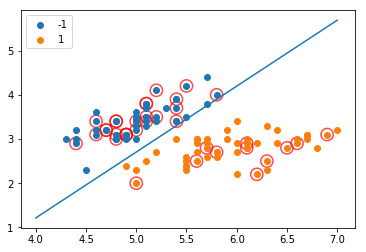

In [42]:
smo=SMO()
smo.fit(X_train,y_train)
smo.score(X_test,y_test)
smo.drawFitLine(X)